# Exploratory Data Analysis of Pharmacological Prescription Data

This notebook performs exploratory data analysis (EDA) on a dataset of pharmacological prescription events. The primary goal is to compute the "event interval" (the difference in days between consecutive medication events for each patient), visualize the empirical cumulative distribution function (ECDF) of these intervals, perform density estimation and clustering using the k-means algorithm, and finally, analyze the duration of filled prescriptions using box plots by prescription order.

This analysis is inspired by the Sessa Empirical Estimator (SEE) approach for computing prescription duration when direct information is missing.




# Clustering & Processing Data with DBSCAN

This main function (`process_medications`) orchestrates the analysis for a given `ATC` code. It:

- Filters the dataset to the chosen `ATC` code.
- Computes the event interval for each patient.
- Generates ECDF plots (80% and 100%) to visualize the distribution of event intervals.
- Subsets the data to the lower 80% of event intervals (to remove outliers such as extremely long intervals).
- Plots the density of the log-transformed event intervals. The plot is annotated with the sample size (`N`) and the estimated bandwidth, which are positioned outside the main plot area using `plt.figtext()`.
- Performs clustering on the subset using **DBSCAN**, a density-based clustering algorithm that automatically identifies outliers as noise points.
- Since DBSCAN does not require specifying the number of clusters beforehand, it is suitable for datasets with varying densities. The `eps` (neighborhood radius) and `min_samples` (minimum points required to form a dense region) parameters are tuned for optimal clustering.
- Finally, it computes a prescription order (`p_number`) for each patient and creates a box plot of event intervals by `p_number`. In this box plot, the overall median is shown as a red dashed line, and the median for each prescription order group is annotated on the plot.

Would you also like me to provide the complete adjusted code with DBSCAN implemented?

## Load Datasets
This part reads the medical events dataset (med_events_ATC.csv) and the tidy dataset (tidy_dataset.csv) into Pandas DataFrames.

In [ ]:
# Load datasets
med_events_df = pd.read_csv('../data/med_events_ATC.csv')
tidy_dataset_df = pd.read_csv('../data/tidy_dataset.csv')

## Preprocessing Functions

This function cleans and prepares the med_events_ATC.csv dataset:

Removes whitespace from column names.
Converts DATE to a proper datetime format.
Converts DURATION and PERDAY to numeric values, coercing invalid ones to NaN.
Drops rows where DURATION or PERDAY contain NaN values.
Encodes categorical columns (CATEGORY_L1 and CATEGORY_L2) into numerical values.

def preprocess_med_events(df):
    df.columns = df.columns.str.strip()  # Ensure no leading/trailing spaces
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df['DURATION'] = pd.to_numeric(df['DURATION'], errors='coerce')
    df['PERDAY'] = pd.to_numeric(df['PERDAY'], errors='coerce')
    df.dropna(subset=['DURATION', 'PERDAY'], inplace=True)  # Remove rows with NaN values in key columns
    label_encoder = LabelEncoder()
    df['CATEGORY_L1_encoded'] = label_encoder.fit_transform(df['CATEGORY_L1'].astype(str))
    df['CATEGORY_L2_encoded'] = label_encoder.fit_transform(df['CATEGORY_L2'].astype(str))
    return df

med_events_df = preprocess_med_events(med_events_df)


## Preprocess tidy_dataset.csv
This function cleans and prepares the tidy_dataset.csv dataset:

Converts eksd (assumed event start date) to datetime format.
Converts perday and dur_original to numeric values, coercing invalid ones to NaN.
Drops rows where perday or dur_original contain NaN values.
Encodes the ATC column into numerical values.

In [ ]:
def preprocess_tidy_dataset(df):
    df['eksd'] = pd.to_datetime(df['eksd'], errors='coerce')
    df['perday'] = pd.to_numeric(df['perday'], errors='coerce')
    df['dur_original'] = pd.to_numeric(df['dur_original'], errors='coerce')
    df.dropna(subset=['perday', 'dur_original'], inplace=True)  # Remove rows with NaN values in key columns
    label_encoder = LabelEncoder()
    df['ATC_encoded'] = label_encoder.fit_transform(df['ATC'].astype(str))
    return df

tidy_dataset_df = preprocess_tidy_dataset(tidy_dataset_df)


## Apply DBSCAN Clustering
This section applies the DBSCAN clustering algorithm to both datasets.

eps=0.5: Defines the neighborhood radius for clustering.
min_samples=5: The minimum number of points required to form a cluster.
The resulting cluster labels are assigned to a new column in each dataset.

In [ ]:
# Select relevant features for clustering
features_med_events = med_events_df[['DURATION', 'PERDAY', 'CATEGORY_L1_encoded', 'CATEGORY_L2_encoded']]
features_tidy_dataset = tidy_dataset_df[['perday', 'dur_original', 'ATC_encoded']]

# Standardize data
scaler = StandardScaler()
scaled_med_events = scaler.fit_transform(features_med_events)
scaled_tidy_dataset = scaler.fit_transform(features_tidy_dataset)

# Apply K-Means
kmeans_med_events = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_tidy_dataset = KMeans(n_clusters=3, random_state=42, n_init=10)

med_events_df['Cluster'] = kmeans_med_events.fit_predict(scaled_med_events)
tidy_dataset_df['Cluster'] = kmeans_tidy_dataset.fit_predict(scaled_tidy_dataset)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
med_events_df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_med_events)


## ECDF (Empirical Cumulative Distribution Function) Plot
This function plots the ECDF of a given dataset to show the cumulative distribution of values.

If percentile is provided, only the lower percentile% of data is shown to reduce the effect of outliers.

In [ ]:
def plot_ecdf(data, title, percentile=None):
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    if percentile:
        max_index = int(len(sorted_data) * (percentile / 100))
        sorted_data = sorted_data[:max_index]
        ecdf = ecdf[:max_index]
    plt.plot(sorted_data, ecdf, label=f'{percentile}% ECDF' if percentile else '100% ECDF')
    plt.legend()
    plt.title(title)


## Data Visualization

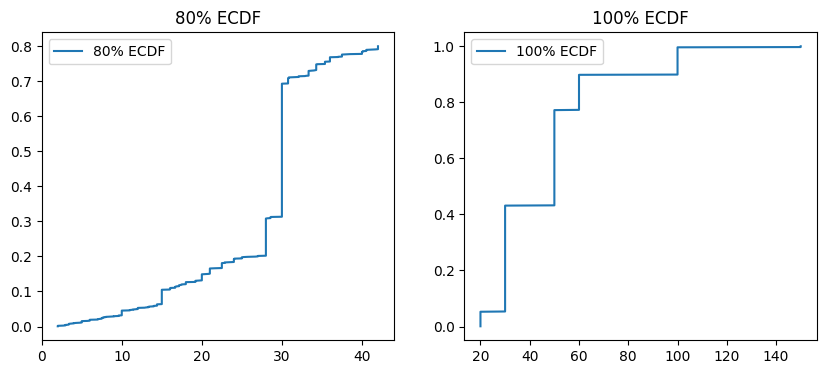

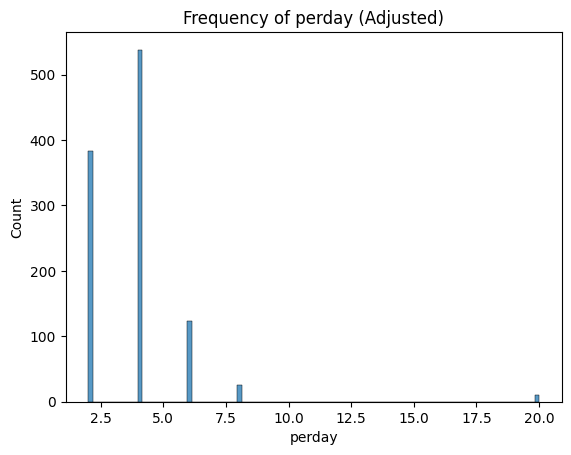

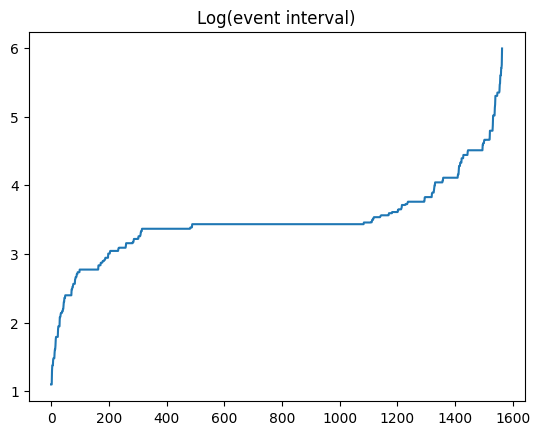

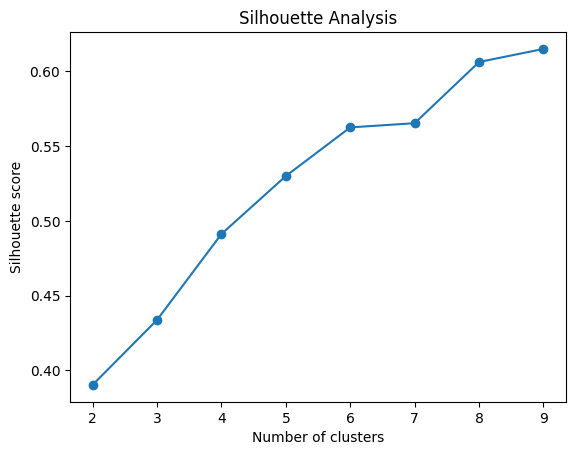

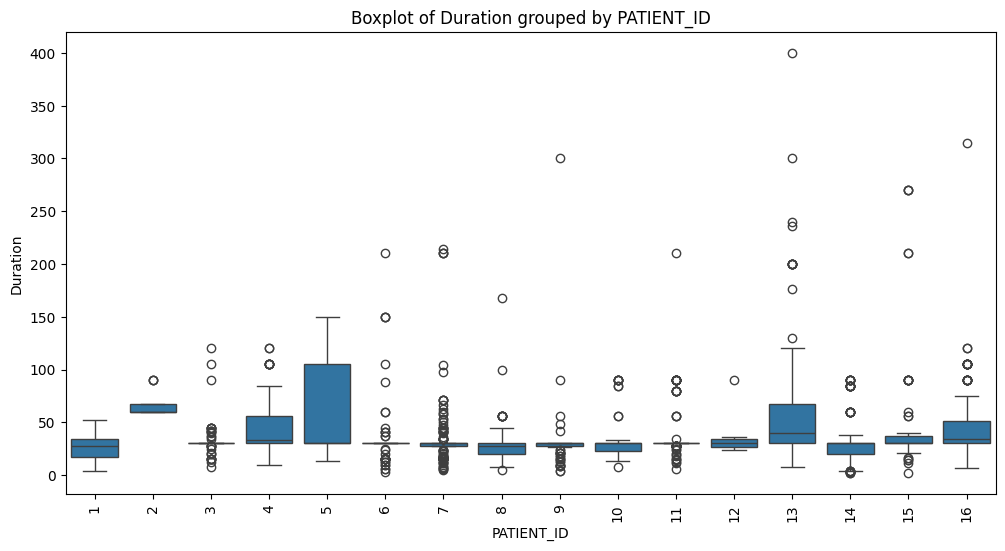

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_ecdf(med_events_df['DURATION'], '80% ECDF', 80)
plt.subplot(1, 2, 2)
plot_ecdf(tidy_dataset_df['dur_original'], '100% ECDF')
plt.show()

# Frequency distribution of perday
sns.histplot(tidy_dataset_df['perday'], bins=100)
plt.title('Frequency of perday (Adjusted)')
plt.show()

# Log event interval plot
log_intervals = np.log1p(med_events_df['DURATION'])
plt.plot(sorted(log_intervals))
plt.title('Log(event interval)')
plt.show()

# Silhouette Analysis
sil_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_med_events)
    sil_scores.append(silhouette_score(scaled_med_events, labels))

plt.plot(range(2, 10), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis')
plt.show()

# Boxplot of Duration grouped by PATIENT_ID
plt.figure(figsize=(12, 6))
sns.boxplot(x='PATIENT_ID', y='DURATION', data=med_events_df)
plt.xticks(rotation=90)
plt.title('Boxplot of Duration grouped by PATIENT_ID')
plt.ylabel('Duration')
plt.xlabel('PATIENT_ID')
plt.show()


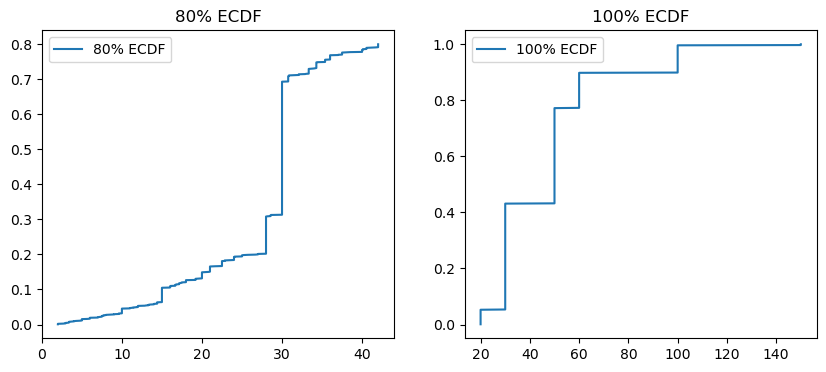

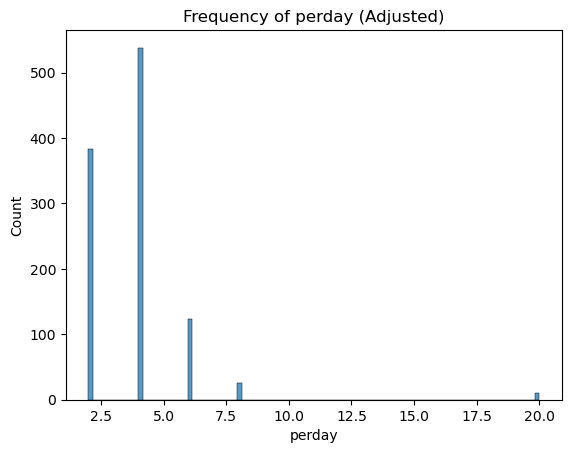

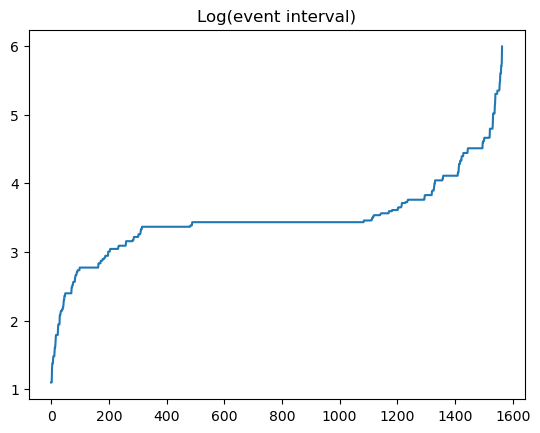

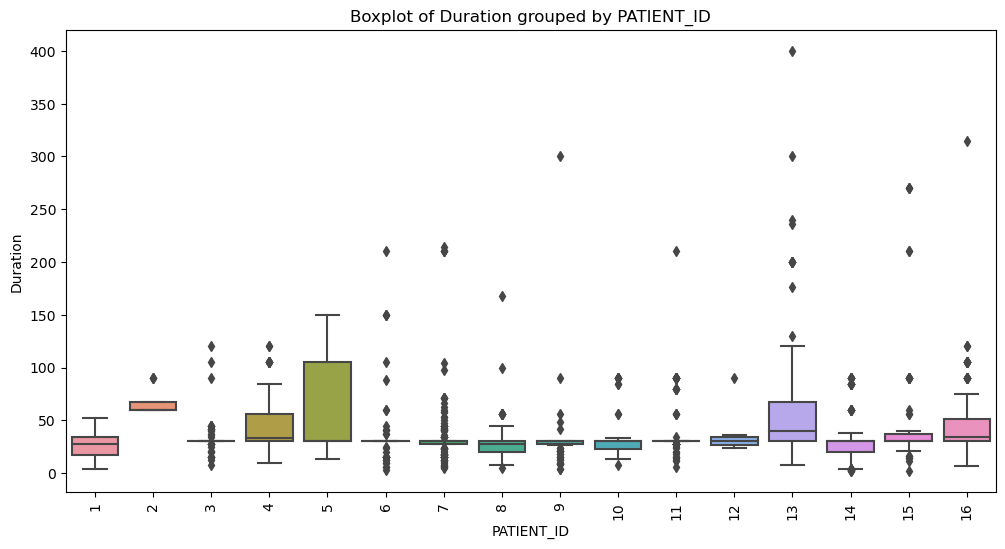

In [ ]:


# Preprocess tidy_dataset.csv
def preprocess_tidy_dataset(df):
    df['eksd'] = pd.to_datetime(df['eksd'], errors='coerce')
    df['perday'] = pd.to_numeric(df['perday'], errors='coerce')
    df['dur_original'] = pd.to_numeric(df['dur_original'], errors='coerce')
    df.dropna(subset=['perday', 'dur_original'], inplace=True)  # Remove rows with NaN values in key columns
    label_encoder = LabelEncoder()
    df['ATC_encoded'] = label_encoder.fit_transform(df['ATC'].astype(str))
    return df

tidy_dataset_df = preprocess_tidy_dataset(tidy_dataset_df)

# Select relevant features for clustering
features_med_events = med_events_df[['DURATION', 'PERDAY', 'CATEGORY_L1_encoded', 'CATEGORY_L2_encoded']]
features_tidy_dataset = tidy_dataset_df[['perday', 'dur_original', 'ATC_encoded']]

# Standardize data
scaler = StandardScaler()
scaled_med_events = scaler.fit_transform(features_med_events)
scaled_tidy_dataset = scaler.fit_transform(features_tidy_dataset)

# Apply DBSCAN
dbscan_med_events = DBSCAN(eps=0.5, min_samples=5)
dbscan_tidy_dataset = DBSCAN(eps=0.5, min_samples=5)

med_events_df['DBSCAN_Cluster'] = dbscan_med_events.fit_predict(scaled_med_events)
tidy_dataset_df['DBSCAN_Cluster'] = dbscan_tidy_dataset.fit_predict(scaled_tidy_dataset)

def plot_ecdf(data, title, percentile=None):
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    if percentile:
        max_index = int(len(sorted_data) * (percentile / 100))
        sorted_data = sorted_data[:max_index]
        ecdf = ecdf[:max_index]
    plt.plot(sorted_data, ecdf, label=f'{percentile}% ECDF' if percentile else '100% ECDF')
    plt.legend()
    plt.title(title)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_ecdf(med_events_df['DURATION'], '80% ECDF', 80)
plt.subplot(1, 2, 2)
plot_ecdf(tidy_dataset_df['dur_original'], '100% ECDF')
plt.show()

# Frequency distribution of perday
sns.histplot(tidy_dataset_df['perday'], bins=100)
plt.title('Frequency of perday (Adjusted)')
plt.show()

# Log event interval plot
log_intervals = np.log1p(med_events_df['DURATION'])
plt.plot(sorted(log_intervals))
plt.title('Log(event interval)')
plt.show()

# Boxplot of Duration grouped by PATIENT_ID
plt.figure(figsize=(12, 6))
sns.boxplot(x='PATIENT_ID', y='DURATION', data=med_events_df)
plt.xticks(rotation=90)
plt.title('Boxplot of Duration grouped by PATIENT_ID')
plt.ylabel('Duration')
plt.xlabel('PATIENT_ID')
plt.show()
